<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [1]:
import os
import sys
import pandas as pd
import pandas_datareader.data as web
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose

# from statsmodels.tsa.seasonal import STL
import scipy.stats as stats
from arch import arch_model
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
sns.set_style('darkgrid')
%matplotlib inline
p = print

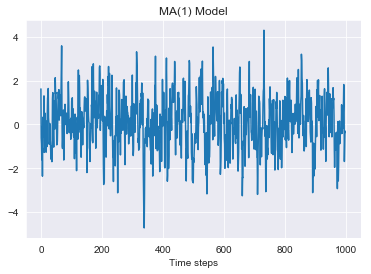

In [2]:
# Moving average order 1 model, MA(1)
np.random.seed(1)
mean, std_dev, n_samples = 0.0, 1.0, 1000
x = w = np.random.normal(loc=mean,scale=std_dev,size=n_samples)
B1 = 0.6
for t in range(2,n_samples):
    x[t] = w[t] + B1*w[t-1]
plt.plot(x)
plt.title('MA(1) Model')
plt.xlabel('Time steps')
plt.show()

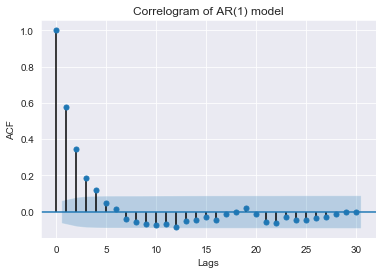

In [3]:
smt.graphics.plot_acf(x,lags=30);
plt.title(f'Correlogram of AR(1) model')
plt.xlabel('Lags')
plt.ylabel('ACF')
plt.show()

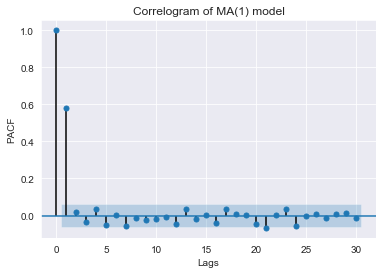

In [4]:
smt.graphics.plot_pacf(x,lags=30);
plt.title(f'Correlogram of MA(1) model')
plt.xlabel('Lags')
plt.ylabel('PACF')
plt.show()

In [5]:
model = smt.ARMA(x, order=(0, 1)).fit(maxlag=30, method='mle',trend='nc')
p(model.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 1000
Model:                     ARMA(0, 1)   Log Likelihood               -1459.456
Method:                           mle   S.D. of innovations              1.041
Date:                Wed, 18 Dec 2019   AIC                           2922.911
Time:                        21:28:47   BIC                           2932.727
Sample:                             0   HQIC                          2926.642
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1.y        0.4578      0.022     20.496      0.000       0.414       0.502
                                    Roots                                    
                  Real          Imaginary           M

In [6]:
model = smt.ARMA(x, order=(0,1)).fit(maxlag=30, ic='aic', trend='nc')
#est_order = smt.ARMA(x,order=(0,1)).select_order(maxlag=30, ic='aic', trend='nc')
true_order = 1
p(f'\nestimated coef: {round(model.params[0],4)}') # | best lag order = {est_order}')
# p(f'\ntrue B1 = {B1} | true order = {true_order}')


estimated coef: 0.4578


According to our model summary, the estimated coefficient = 0.4578, but the true coefficient = 0.6. Is the model summary incorrect? To answer this question, We will use an alternate method of generating simulations of a MA(p) process.

In [7]:
# Simulate an MA(1) process
n = int(1000)
# set the AR(p) alphas equal to 0
alphas = np.array([0.])
betas = np.array([0.6])
# add zero-lag and negate alphas
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]
ma1 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n)

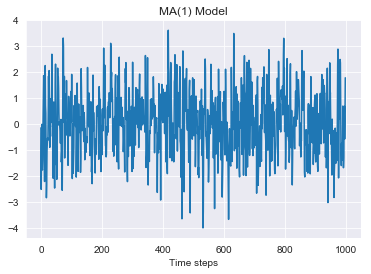

In [8]:
plt.plot(ma1)
plt.title('MA(1) Model')
plt.xlabel('Time steps')
plt.show()

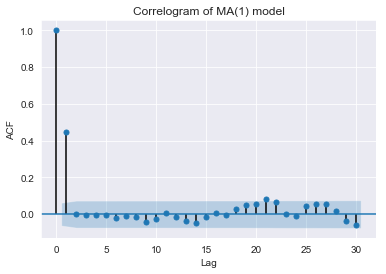

In [9]:
smt.graphics.plot_acf(ma1,lags=30);
plt.title(f'Correlogram of MA(1) model')
plt.xlabel('Lag')
plt.ylabel('ACF')
plt.show()

In [10]:
mdl = smt.ARMA(ma1, order=(0, 1)).fit(
    maxlag=30, method='mle', trend='nc')
p(mdl.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 1000
Model:                     ARMA(0, 1)   Log Likelihood               -1448.721
Method:                           mle   S.D. of innovations              1.030
Date:                Wed, 18 Dec 2019   AIC                           2901.441
Time:                        21:28:48   BIC                           2911.257
Sample:                             0   HQIC                          2905.172
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1.y        0.6158      0.026     23.947      0.000       0.565       0.666
                                    Roots                                    
                  Real          Imaginary           M

The estimated coefficient is not far from the true coefficient. Additionally, the 95% confidence interval (0.575, 0.668) contains the true coefficent value B1 = 0.6. Therefore, the model is a good fit as expected since we simulated the time-series data.

In [11]:
# Simulate an MA(1) process
n = int(1000)
# set the AR(p) alphas equal to 0
alphas = np.array([0.])
# Now the coefficient is negative B1 = -0.6
betas = np.array([-0.6])
# add zero-lag and negate alphas
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]
ma1 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n)

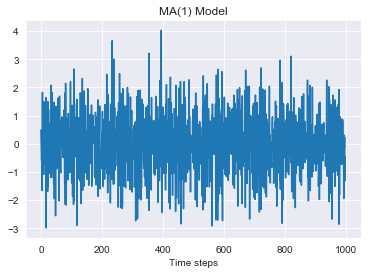

In [12]:
plt.plot(ma1)
plt.title('MA(1) Model')
plt.xlabel('Time steps')
plt.show()

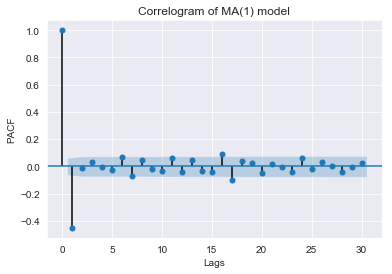

In [13]:
smt.graphics.plot_acf(ma1,lags=30);
plt.title(f'Correlogram of MA(1) model')
plt.xlabel('Lags')
plt.ylabel('PACF')
plt.show()

In [14]:
mdl = smt.ARMA(ma1, order=(0, 1)).fit(maxlag=30, method='mle', trend='nc')
p(mdl.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 1000
Model:                     ARMA(0, 1)   Log Likelihood               -1390.392
Method:                           mle   S.D. of innovations              0.972
Date:                Wed, 18 Dec 2019   AIC                           2784.785
Time:                        21:28:49   BIC                           2794.600
Sample:                             0   HQIC                          2788.515
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1.y       -0.6169      0.024    -25.727      0.000      -0.664      -0.570
                                    Roots                                    
                  Real          Imaginary           M

In [15]:
# Simulate an MA(3) process
n = int(1000)
# set the AR(p) alphas equal to 0
alphas = np.array([0.])
betas = np.array([0.6, 0.4, 0.3])
# add zero-lag and negate alphas
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]
ma3 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n)

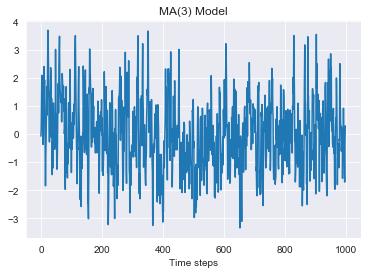

In [16]:
plt.plot(ma3)
plt.title('MA(3) Model')
plt.xlabel('Time steps')
plt.show()

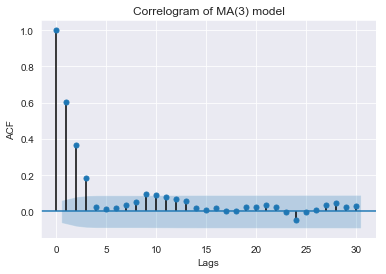

In [17]:
smt.graphics.plot_acf(ma3,lags=30);
plt.title(f'Correlogram of MA(3) model')
plt.xlabel('Lags')
plt.ylabel('ACF')
plt.show()

In [18]:
model = smt.ARMA(ma3, order=(0, 3)).fit(maxlag=30, method='mle', trend='nc')
p(model.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 1000
Model:                     ARMA(0, 3)   Log Likelihood               -1427.086
Method:                           mle   S.D. of innovations              1.008
Date:                Wed, 18 Dec 2019   AIC                           2862.171
Time:                        21:28:50   BIC                           2881.802
Sample:                             0   HQIC                          2869.632
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1.y        0.6029      0.031     19.624      0.000       0.543       0.663
ma.L2.y        0.4047      0.034     11.980      0.000       0.338       0.471
ma.L3.y        0.2674      0.030      8.806      0.0

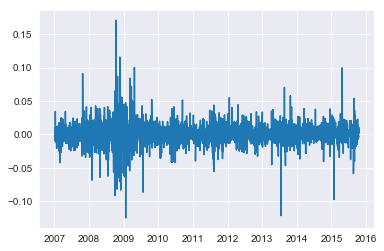

In [19]:
df = web.DataReader(['MSFT','^GSPC'],'yahoo','01/01/2007','10/18/2015')['Adj Close']
log_rets = np.log(df).diff().dropna()
plt.plot(log_rets['MSFT']);
# df.head()
# plt.plot(df['Adj Close'])
# plt.show()

In [20]:
# df.head()

In [21]:
# np.log(df).head()

In [22]:
# logrets = np.log(df) - np.log(df.shift(1))
# logrets.head()

In [23]:
# logrets = np.log(df).diff().dropna()
# logrets.head()

In [24]:
model = smt.ARMA(log_rets['MSFT'].values, order=(0, 1)).fit(maxlag=30, method='mle', trend='nc')
p(model.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 2214
Model:                     ARMA(0, 1)   Log Likelihood                5740.880
Method:                           mle   S.D. of innovations              0.018
Date:                Wed, 18 Dec 2019   AIC                         -11477.761
Time:                        21:28:53   BIC                         -11466.356
Sample:                             0   HQIC                        -11473.595
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1.y       -0.0696      0.022     -3.116      0.002      -0.113      -0.026
                                    Roots                                    
                  Real          Imaginary           M

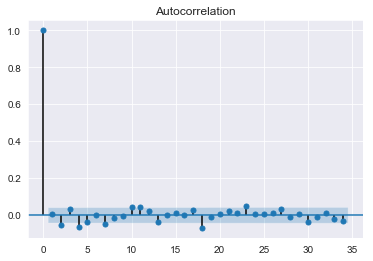

In [25]:
# plot acf of residuals
smt.graphics.plot_acf(model.resid);

search: plot of acf residuals [link](https://www.google.com/search?rlz=1C1EJFA_enUS660US667&sxsrf=ACYBGNRrU01zm24rOhfr6VU3wmr5eFCHlA%3A1572011934958&ei=nv-yXfD_OczM_AaWsrb4BQ&q=python+statsmodels+plot+acf+of+residuals&oq=python+statsmodels+plot+acf+of+residuals&gs_l=psy-ab.3..33i299l3.3414.9966..13080...2.2..0.102.913.11j1......0....1..gws-wiz.......0i71j35i304i39j35i39.YHpnXwTM4Sw&ved=0ahUKEwjwxtznyLflAhVMJt8KHRaZDV8Q4dUDCAs&uact=5)

In [26]:
model = smt.ARMA(log_rets['MSFT'].values, order=(0, 2)).fit(maxlag=30, method='mle', trend='nc')
p(model.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 2214
Model:                     ARMA(0, 2)   Log Likelihood                5744.339
Method:                           mle   S.D. of innovations              0.018
Date:                Wed, 18 Dec 2019   AIC                         -11482.677
Time:                        21:28:53   BIC                         -11465.569
Sample:                             0   HQIC                        -11476.428
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1.y       -0.0623      0.021     -2.916      0.004      -0.104      -0.020
ma.L2.y       -0.0608      0.023     -2.637      0.008      -0.106      -0.016
                                    Roots           

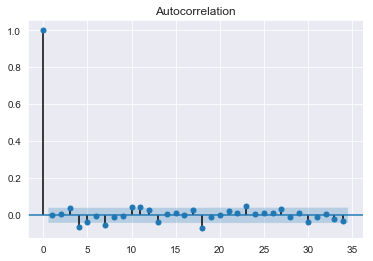

In [27]:
# plot acf of residuals
smt.graphics.plot_acf(model.resid);

In [28]:
model = smt.ARMA(log_rets['MSFT'].values, order=(0, 3)).fit(maxlag=30, method='mle', trend='nc')
p(model.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 2214
Model:                     ARMA(0, 3)   Log Likelihood                5745.261
Method:                           mle   S.D. of innovations              0.018
Date:                Wed, 18 Dec 2019   AIC                         -11482.521
Time:                        21:28:54   BIC                         -11459.711
Sample:                             0   HQIC                        -11474.189
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1.y       -0.0600      0.021     -2.815      0.005      -0.102      -0.018
ma.L2.y       -0.0601      0.023     -2.628      0.009      -0.105      -0.015
ma.L3.y        0.0292      0.022      1.359      0.1

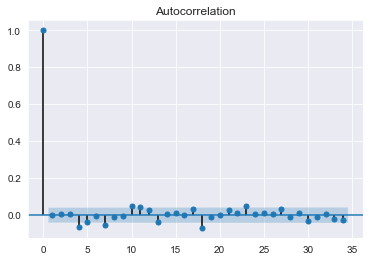

In [29]:
# plot acf of residuals
smt.graphics.plot_acf(model.resid);

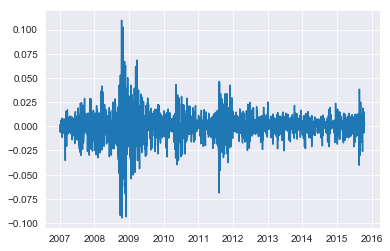

In [30]:
df = web.DataReader(['MSFT','^GSPC'],'yahoo','01/01/2007','10/18/2015')['Adj Close']
log_rets = np.log(df).diff().dropna()
plt.plot(log_rets['^GSPC']);

In [31]:
model = smt.ARMA(log_rets['^GSPC'].values, order=(0, 1)).fit(maxlag=30, method='mle', trend='nc')
p(model.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 2214
Model:                     ARMA(0, 1)   Log Likelihood                6368.114
Method:                           mle   S.D. of innovations              0.014
Date:                Wed, 18 Dec 2019   AIC                         -12732.229
Time:                        21:28:56   BIC                         -12720.824
Sample:                             0   HQIC                        -12728.062
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1.y       -0.1187      0.022     -5.355      0.000      -0.162      -0.075
                                    Roots                                    
                  Real          Imaginary           M

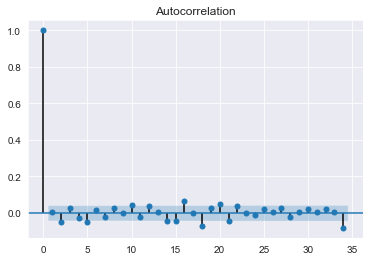

In [32]:
# plot acf of residuals
smt.graphics.plot_acf(model.resid);

In [33]:
model = smt.ARMA(log_rets['^GSPC'].values, order=(0, 2)).fit(maxlag=30, method='mle', trend='nc')
p(model.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 2214
Model:                     ARMA(0, 2)   Log Likelihood                6371.146
Method:                           mle   S.D. of innovations              0.014
Date:                Wed, 18 Dec 2019   AIC                         -12736.293
Time:                        21:28:57   BIC                         -12719.185
Sample:                             0   HQIC                        -12730.043
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1.y       -0.1098      0.021     -5.144      0.000      -0.152      -0.068
ma.L2.y       -0.0549      0.022     -2.473      0.013      -0.098      -0.011
                                    Roots           

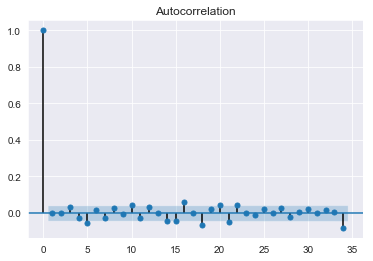

In [34]:
# plot acf of residuals
smt.graphics.plot_acf(model.resid);

In [35]:
model = smt.ARMA(log_rets['^GSPC'].values, order=(0, 3)).fit(maxlag=30, method='mle', trend='nc')
p(model.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 2214
Model:                     ARMA(0, 3)   Log Likelihood                6371.829
Method:                           mle   S.D. of innovations              0.014
Date:                Wed, 18 Dec 2019   AIC                         -12735.658
Time:                        21:28:57   BIC                         -12712.847
Sample:                             0   HQIC                        -12727.325
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1.y       -0.1095      0.021     -5.159      0.000      -0.151      -0.068
ma.L2.y       -0.0552      0.022     -2.500      0.012      -0.098      -0.012
ma.L3.y        0.0243      0.021      1.169      0.2

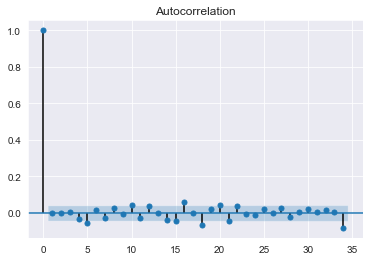

In [36]:
# plot acf of residuals
smt.graphics.plot_acf(model.resid);